# How do we judge our motion through a dynamic environment?

Imagine you are driving a car. You see stationary objects (such as trees and buildings) and objects that move independently (other cars on the street). In order to navigate to your desired location, you need to know how you are moving and then course-correct accordingly.


But, the brain does not **know** how you are moving. It only has access to sensory signals from which it can infers how you are moving. I only consider visual cues here. The visual motion cues available are:  (1) motion of the obserever with respect to stationary objects in the environment `xvis` (patterns of stationary objects moving on the retina); and (2) motion of objects relative to the observer `xobj`. 

I propose that the brain implements a decision process, causal inference, to judge how the observer is moving in the environment. The Bayesian model that formalizes the causal inference process is a 3-step process.

1. The model first predicts if the object is stationary or moving in the world (see also Part 1).

2. It then predicts observer's self-motion velocity if the object was indeed stationary (C = 1 scenario) and if the object was indeed moving independently (C = 2 scenario). 

3. The model then calculates the most likely self-motion velocity as a sum of the self-motion vectors weighted by the respective posterior probabilities.

     
4. In-line with the binary classification design adopted throughout, given only visual cues about observer's motion (`xvis`) and visual cues about object's motion on the retina  (`xobj`), the model predicts if the observer was moving "Rightward" or "Leftward" taking into account the polarity of S^.

**Novelty of the Bayesian Model**
The model predicts how the observer estimates his/her self-motion when there are other objects in the environment. Specifically, the model predicts that the accuracy of how an observer judges his/her self-motion depends on the speed of external objects in his environment.

* If the observer perceives the object to be stationary in the world, the observer attributes the viewed motion of the object to his/her own movement. Thus, at slow speeds, when the object is not truly stationary in the world, the observer mis-attributes the viewed object cues to his/her movement. This leads to errors in observer's perception. 

* If the observer perceives the object to move independently in the world, the observer ignores the motion of the object. At fast object speeds, the observer ignores the visual cues related to the object. This would lead to smaller errors in how the observer perceives his/her movement.

**Thus, the Bayesian model predicts that at slow object speeds, the model predicts larger errors in perceived self-motion. The error in perceived self-motion decreases as the object moves faster.**


The behavioral data that will serve as a validation for this model has been published in the **Proceedings of the National Academy of Sciences**. __[Article Link](https://www.pnas.org/content/116/18/9060.short?rss=1)__


In [6]:
import numpy as np
from scipy import special
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Defining the range of observer's self-motion direction.  
# -45 deg = subject is moving to left at an angle of 45 deg from the center line.
# +30 deg = subject is moving to the right at an angle of 30 deg from the center line.

bodyangle = np.array([-45, 45] + list(range(-25,30,5)))
bodyangle.sort()

# Distance traveled by the observer at the specified direction.

dist = 13


# Calculating the velocity of observer's body motion, also called self-motion velocity.

bodymotion = dist * bodyangle * (3.14/180)

In [8]:
# Defining the range of object motion velocities. 

# Object velocity = -200 cm/s --> Object is moving fast in a straight line from right to left.
# Object velocity = +25 cm/s --> Object is moving slow from left to right.

objmotion = np.array([-200, -100, -50, -25, -10, -5, -2.5, 0, 2.5, 5, 10, 25, 50, 100, 200])


In [9]:
# I assume that visual signals indicating self-motion, xvis, is corrupted by Gaussian noise. 

# Noise in the visual signals xvis.
sigmavis = 3

# I also assume that visual signals indicating object's motion is corrupted by Gaussian noise.

# Noise in visual object motion signals. 
sigmaobj = 3

# The model assumes that observer's velocity is drawn from a Gaussian distribution 
# with width sigmap.

sigmap = 10

# The model assumes that object's velocity is drawn from a Gaussian distribution 
# with width sigmao.

sigmao = 100

# Calculating the inverse variance for ease of mathematical expressions.
Jvis = 1/(sigmavis**2)
Jobj = 1/(sigmaobj**2)
Jp   = 1/(sigmap**2)
Jo   = 1/(sigmao**2)

# The calculations that are fundamental backbone of the model have been analytically 
# solved by hand and verfied in Mathematica.
# J4 is a term that occurs during this solution.

J4 = Jobj*Jo/(Jobj+Jo)



# The model takes into account the prior probability that in general an object would be
# stationary or moving in the world. The model here assumes that to be equal for a 
# stationary and moving object.

pcommon = 0.5



In [10]:
# The model makes prediction for each trial/sample of the visual cues. Each sample 
# simulates the cues experienced by the observer in each trial.

no_samples = 1000

In [11]:
# Creating a matrix of self-motion velocity for easy matrix manipulation.

[heading_orig, obj_orig] = np.meshgrid(bodymotion, objmotion)
heading_orig = heading_orig.reshape(heading_orig.shape[0],heading_orig.shape[1],1)
heading = np.repeat(heading_orig, no_samples, axis=2)

In [12]:
# Creating a matrix of object velocity for easy matrix manipulatiton.

obj_orig = obj_orig.reshape(obj_orig.shape[0],obj_orig.shape[1],1)
objvel = np.repeat(obj_orig, no_samples, axis=2)

In [13]:
# Simulating noisy visual heading samples.

# Note that visual cues indicating observer's self-motion depends on observer's motion
# alone.

xvis = heading + sigmavis * np.random.normal(0,1,(heading.shape[0], heading.shape[1], heading.shape[2]))

In [14]:
# Simulating noisy retinal object motion samples.

# Note here that xobj depends on observer's self-velocity ('heading') and
# object's true velocity (objvel)

xobj = heading - objvel + sigmaobj * np.random.normal(0,1,(heading.shape[0],heading.shape[1],heading.shape[2]))

#### Step 1: Determining whether the object is stationary or moving in the world.

In [15]:
# Calculating the likelihood that the object is stationary (see Part 1 notebook).

pC1_constant = 1/(2*np.pi) * np.sqrt(   Jvis*Jobj*Jp/( (2*np.pi)*(Jvis+Jobj+Jp)    )   )
pC1_expterm = ( Jvis*Jobj*((xvis-xobj)**2) + Jp*Jobj*(xobj**2) + Jp*Jvis*(xvis**2) )/(Jvis+Jobj+Jp)
pC1 = pC1_constant * np.exp(-0.5 * pC1_expterm)

In [16]:
# Calculating the likelihood that the object is moving  (see Part 1 notebook).

pC2_constant = 1/(2*np.pi) * np.sqrt(  (Jvis*Jp*J4) / (2*np.pi* (Jvis+Jp+J4) )  )
pC2_expterm = Jvis*Jp*(xvis**2) + Jp*J4*(xobj**2) + Jvis*J4*( (xvis-xobj)**2) / (Jvis+Jp+J4)
pC2 = pC2_constant * np.exp(-0.5 * pC2_expterm)

In [17]:
# Calculating the posterior probability.

p_C1_C2 = pC1*pcommon/(pC2*(1-pcommon))

In [18]:
# Finding out the trials in which the the ratio of the posterior probability > 1.

bool_p_C1_C2 = p_C1_C2 > 1

In [19]:
# For each combination of object and observer velocity, calculate proportion of trials 
# in which the object was perceived to be stationary.

prop_OS = bool_p_C1_C2.sum(axis=2)/no_samples

In [20]:
prop_OS.mean(axis=1)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.53846154e-04,
       5.27153846e-01, 8.98923077e-01, 9.68153846e-01, 9.87846154e-01,
       9.67769231e-01, 9.00538462e-01, 5.23769231e-01, 2.30769231e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

C:\Users\D\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\Users\D\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


Text(0, 0.5, 'Prop. object stationary reports')

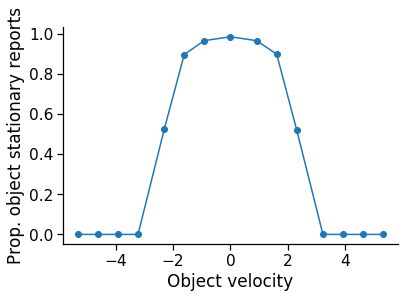

In [21]:
sns.set_style()
sns.set_context(context='notebook',font_scale = 1.4)

# Converting the object velocity to be plotted on a log-scale.
xvar = np.nan_to_num(np.sign(objmotion)*np.log(np.abs(objmotion)))

plt.plot(xvar, prop_OS.mean(axis=1), marker='o')
sns.despine()
plt.xlabel('Object velocity')
plt.ylabel('Prop. object stationary reports')


####  Step 2: Calculating obserever's self-motion velocity if the object was stationary (`Stheta_C1`) and if the object was moving (`Stheta_C2`). 

In [22]:
# Calculating self-motion velocity if object is perceived to be stationary (C=1).

Stheta_C1 = (  xvis/(sigmavis**2) + xobj/(sigmaobj**2)  ) / (  1/(sigmavis**2) + 1/(sigmaobj**2) + 1/(sigmap**2) )

In [23]:
# Calculating the self-motion velocity if object is perceived to be moving (C=2).

Stheta_C2 = (  xvis/(sigmavis**2) + xobj/(sigmaobj**2 + sigmao**2)  ) / (  1/(sigmavis**2) + 1/(sigmao**2 + sigmaobj**2) + 1/(sigmap**2)  )

#### Step 3: Calculating the composite final self-motion velocity, the observer's motion vector, as a sum of the two estimates, `Stheta_C1` and `Stheta_C2`, and weighting them with their respective posterior probabilities, `pC1` and `pC2`.

If the object is more likely to be stationary, `Stheta_C1` will have a bigger contribution in the final estimate. Since `Stheta_C1` incorporates object signals `xobj`, `Stheta_C1` will be more different from the true self-motion velocity. Consequently, `Stheta` will have more errors when object is perceived to be stationary. 

In [25]:
# Predicting the composite self-motion velocity.

Stheta = np.multiply(pC1, Stheta_C1) + np.multiply(pC2, Stheta_C2)

In [26]:
# The model predicts observer moved to the RIGHT if Stheta > 0.


bool_Stheta = Stheta > 0

In [27]:
# Calculating the proportion of trials in which model predicted RIGHTWARD movement
# for each object velocity.

propR = bool_Stheta.sum(axis=2)/no_samples

The model predicts a binary response: 1 = observer moved to the **RIGHT** (S^ > 0).
0 = observer moved to the **LEFT** (S^ < 0).

To evaluate how object speed influenced the self-motion discrimination, a Cumulative Gaussian function is fitted to the data with:
x = true body velocity (as defined at the start), `bodymotion` variable.
y = proportion of **Rightward** responses as predicted by the ideal observer (model).

The $\mu$ of the fits represents the error between the observer's actual self-motion and his/her perceived self-motion

In [28]:
# Defining the cumulative gaussian function.

def cumgauss(x,bias,thr):
    return 0.5*(1 + special.erf( (x - bias)/(np.sqrt(2)*thr) ) )

`cumgauss` function is fitted to the proportion of Rightward responses at each object velocity using `curve_fit` optimization routine.

In [29]:
# Fitting cumulative gaussian to data at each object velocity.

params = np.ones((objmotion.shape[0],2))

for i in range(0,15):
    params[i,:], x_cov = curve_fit(cumgauss, bodyangle, propR[i,:])
   

C:\Users\D\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\D\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Heading error (deg)')

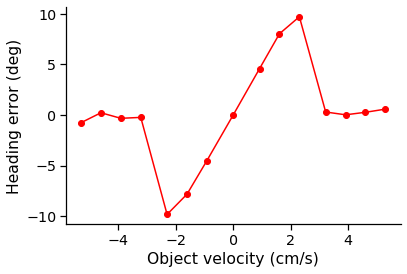

In [31]:
# Plotting the error in self-motion perception as a function of object velocity.

xvar= np.nan_to_num(np.sign(objmotion) *np.log(np.abs(objmotion)))

# The warning below is related to creating the dummy x-variable for easy visualization 
# of the model predictions. The warning is not related to performance of the model.


import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(xvar, params[:,0], marker='o',color='red')

sns.set_style()
sns.set_context(context='notebook',font_scale = 1.3)
sns.despine()
plt.xlabel('Object velocity (cm/s)')
plt.ylabel('Heading error (deg)')

Note that the X-axis is logarithmically scaled to better see the patterns at slow object speeds.

## Thus, the Bayesian model predicts larger errors in self-motion judgement when there are slow-moving objects in the environment.

#### The Bayesian model predicts perfectly match the behavioral data collected by testing human subjects and macaque monkeys in an identical behavioral task.

The behavioral data is published in the **Proceedings of the National Academy of Sciences**.